In [1]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import experiments.parameters as parameters
from environments.observation_embeddings import CoordinateEmbedding, ObservationEmbedding


In [2]:
parameters.env_challenges[2]

{'max_episode_length': 100,
 'iterations': 30,
 'observation_embedding': 'coordinate',
 'puct_c': 1.0,
 'eval_param': 10.0,
 'n_steps_learning': 1,
 'env_description': 'FrozenLake-v1-4x4',
 'ncols': 4,
 'env_params': {'id': 'FrozenLake-v1',
  'desc': ['SFFF', 'FHFH', 'FFFH', 'HFFG'],
  'is_slippery': False,
  'max_episode_steps': 1000000000,
  'hole_reward': -1.0},
 'discount_factor': 0.9,
 'optimal_value': 0.5904900000000001,
 'worst_value': -1.0,
 'training_epochs': 2}

In [3]:
from core.mcts import LakeDistanceMCTS
from log_code.investigate_model import create_figure_and_axes, plot_value_network


challenge = parameters.env_challenges[2]

hparams = {**parameters.base_parameters, **challenge}
env = gym.make(**hparams["env_params"])
observation_embedding: ObservationEmbedding = CoordinateEmbedding(env.observation_space, hparams["ncols"] if "ncols" in hparams else 12)

lake_map = hparams["env_params"]["desc"]
agent = LakeDistanceMCTS(
    lake_map,
    root_selection_policy=None,
    selection_policy=None,
    discount_factor=hparams["discount_factor"],
    )

rows, cols = observation_embedding.nrows, observation_embedding.ncols

def investigate_model():
    return {obs: agent.get_value(obs) for obs in range(observation_embedding.observation_space.n)}

output = investigate_model()
output

nrows: 4, ncols: 4


{0: 0.531441,
 1: 0.5904900000000001,
 2: 0.6561,
 3: 0.5904900000000001,
 4: 0.5904900000000001,
 5: 0.0,
 6: 0.7290000000000001,
 7: 0.0,
 8: 0.6561,
 9: 0.7290000000000001,
 10: 0.81,
 11: 0.0,
 12: 0.0,
 13: 0.81,
 14: 0.9,
 15: 0.81}

In [4]:
agent.distances

{(3, 3): 2,
 (3, 2): 1,
 (3, 1): 2,
 (2, 2): 2,
 (2, 1): 3,
 (1, 2): 3,
 (2, 0): 4,
 (0, 2): 4,
 (1, 0): 5,
 (0, 3): 5,
 (0, 1): 5,
 (0, 0): 6}

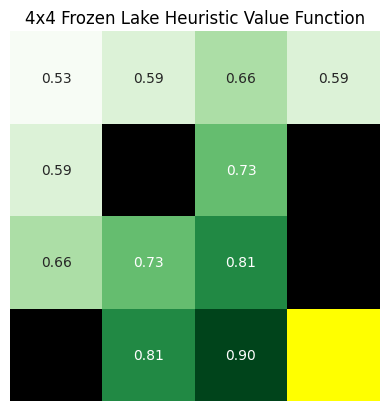

In [5]:

grid = np.zeros((rows, cols))
for state, value in output.items():
    row, col = divmod(state, cols)
    grid[row, col] = value

cliff_coords = [(r, c) for r, row in enumerate(lake_map) for c, char in enumerate(row) if char == 'H']
goal_coord = next((r, c) for r, row in enumerate(lake_map) for c, char in enumerate(row) if char == 'G')

nrows = grid.shape[0]
ncols = grid.shape[1]
# Cliff and goal state coordinates

# Set cliff and goal states to np.nan to hide their annotations
for (row, col) in cliff_coords:
    grid[row, col] = np.nan  # Remove numbers from the cliff cells
goal_row, goal_col = goal_coord
grid[goal_row, goal_col] = np.nan  # Remove numbers from the goal cell
# turn of axis labels
sns.heatmap(grid, annot=True, fmt=".2f", cbar=False, square=True, cmap="Greens", xticklabels=False, yticklabels=False)

for (row, col) in cliff_coords:
    plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=True, color='black', lw=0))

    # Highlight the goal state with yellow color
    plt.gca().add_patch(plt.Rectangle((goal_col, goal_row), 1, 1, fill=True, color='yellow', lw=0))
plt.title("4x4 Frozen Lake Heuristic Value Function")
plt.savefig(f"outfiles/lake_heuristic_value_function.pdf", bbox_inches='tight')
plt.show()